# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## The TrafficSignClassifier class
The complete sourcecode necessary for this project is encapsulated in a single TrafficSignClassifier class. The intention to write this class instead of using the jupyter notebook only is based on the flexibility and confort a regular python editor offers me.

This class was designed to allow to run multiple testruns with different configuration in a multithreaded (unfortunately my machine is to weak to really run multithreaded) or sequential order. The idea was to make different approaches tweaking the parameters and start overnight testruns.

Sorry for the inconvenience to have one big block of source instead of the structur provided via this template. Anyway - I've added execution code to each cell and refer to the corredponding line in this class.

In [1]:
'''
Created on 13.06.2017

@author: Michael Scharf
@email: mitschen@gmail.com
'''

#used for the import of the TrafficSignData
import pickle
#read the csv file
import csv
from sklearn.utils import shuffle 
import os
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.ticker import LinearLocator
from tensorflow.contrib.layers import flatten
import tensorflow as tf

import threading     
import time
import math
import datetime


import scipy.ndimage  
import scipy.misc

C_TESTFILENAME = "test.p"
C_TRAINFILENAME = "train.p"
C_VALIDATIONFILENAME = "valid.p"
C_CLASSFILENAME = "signnames.csv"


class DefaultLoggerClient():
    def log(self, txt = None):
        if txt is None:
            return
        print (txt)

class LoggerClient():
    def __init__(self, _id, theLogger):
        assert(isinstance(theLogger, Logger))
        self.__id = _id
        self.__logger = theLogger
        
    def log(self, txt = None):
        if txt is None:
            return
        self.__logger._Logger__log(self.__id, txt)
        
        
class Logger():
    __mutexLock = threading.Lock()
    def __init__(self, outfile, toConsole = False):
        self.__filepath = outfile
        self.__content = {}
        self.__toConsole = toConsole
        
    def __log(self, _id, data):
        with Logger.__mutexLock:
            if (_id in self.__content.keys()):
                self.__content[_id].append(data)
                if(self.__toConsole == True):
                    print(data)
            else:
                self.__content[_id] = [data]
                
    def getLogger(self, _id):
        return LoggerClient(_id, self)
                
    def dump(self):
        toWrite = "\n\n"+str(datetime.datetime.now())+"\n";
        for key, val in self.__content.items():
            toWrite += "Entity {0:d}:\n".format(key)
            toWrite += "\n".join(val)
            #toWrite += string.join((list( map(lambda x : x+"\n", val))))
        with open(self.__filepath, "a") as f:
            f.write(toWrite)
        self.__content = {}
                

class TrafficSignClassifier():
    #static section
    #data we're reading from the traffic-signs data
    #This members are the input variables for any TrafficSignClassifier instance
    #    which might be configured with different values
    X_train = None
    Y_train = None
    X_valid = None
    y_valid = None
    X_test = None
    y_test = None
    X_custom = None
    y_custom = None
    classes = None
    #values are getting initializes during __preAnalyzeData
    #for each label, a list of index to the corresponding trainingInput
    trainingLabelSetIndex = None
    #unique id of each instance
    id = 0
    
    def __getId():
        #get a unique id for an instance
        #Used for multithreaded runtime to allow to associate the results
        #to a certain configuration
        TrafficSignClassifier.id+=1
        return TrafficSignClassifier.id
    
    def importData(filepath):
        #import the set of testdata once
        #This method is called once. All information are read into the
        #static member variables and then are shared between all
        #instances 
        training_file = os.path.join(filepath, C_TRAINFILENAME)
        validation_file= os.path.join(filepath, C_VALIDATIONFILENAME)
        testing_file = os.path.join(filepath, C_TESTFILENAME)
        csv_file = os.path.join(filepath, C_CLASSFILENAME)
        TrafficSignClassifier.classes = {}
        with open(training_file, mode='rb') as f:
            train = pickle.load(f)
        with open(validation_file, mode='rb') as f:
            valid = pickle.load(f)
        with open(testing_file, mode='rb') as f:
            test = pickle.load(f)
        with open(csv_file, mode='r') as f:
            reader = csv.DictReader(f, delimiter=',')
            for row in reader:
                TrafficSignClassifier.classes[row['ClassId']] = [row['SignName'], 0]

        assert('features' in train.keys())
        assert('labels' in train.keys())
        assert('features' in valid.keys())
        assert('labels' in valid.keys())
        assert('features' in test.keys())
        assert('labels' in test.keys())
        
            
        TrafficSignClassifier.X_train, TrafficSignClassifier.y_train = train['features'].astype(np.float32), train['labels']
        TrafficSignClassifier.X_valid, TrafficSignClassifier.y_valid = valid['features'].astype(np.float32), valid['labels']
        TrafficSignClassifier.X_test, TrafficSignClassifier.y_test = test['features'].astype(np.float32), test['labels']
        
        #the number of classes should be given by the different classIdentifiers 
        #provided in the set of train, test and validation results
        noClasses = set(TrafficSignClassifier.y_valid)
        noClasses.update(set(TrafficSignClassifier.y_train))
        noClasses.update(set(TrafficSignClassifier.y_test))
        assert(len(noClasses) == len(TrafficSignClassifier.classes.keys()))
        print("Files under ", os.path.abspath(filepath), "read\nwith size of (",TrafficSignClassifier.X_train.shape, TrafficSignClassifier.X_valid.shape, TrafficSignClassifier.X_test.shape,")\n")
        TrafficSignClassifier.__printSummary()
    
    def importCustomImages(filepath, fileList):
        #import custom bmp images and store them as
        files = []
        TrafficSignClassifier.y_custom = []
        TrafficSignClassifier.X_custom = [] 
        #compose fqnames and store the labels
        for val in fileList:
            files.append(os.path.join(filepath, val[0]))
            TrafficSignClassifier.y_custom.append(val[1])
        for f in files:
            TrafficSignClassifier.X_custom.append(scipy.misc.imread(f))
        TrafficSignClassifier.X_custom = np.array(TrafficSignClassifier.X_custom).astype(np.float32)
        TrafficSignClassifier.y_custom = np.array(TrafficSignClassifier.y_custom)
        
    def __printSummary(header = "Basic Summary of the DataSet"):
        #print a summary according to Jupyter Notebook requirements
        print(header)
        print("\tNumber of training examples = ", TrafficSignClassifier.X_train.shape[0])
        print("\tNumber of validation examples = ", TrafficSignClassifier.X_valid.shape[0])
        print("\tNumber of testing examples = ", TrafficSignClassifier.X_test.shape[0])
        print("\tImage data shape = ", (TrafficSignClassifier.X_train.shape[1], TrafficSignClassifier.X_train.shape[2]))
        print("\tNumber of classes = ", len(TrafficSignClassifier.classes.keys()))
    
    
    def preAnalyzeData():
        #make a statistic of how the training data is distributed
        #this method provides a graphical overview of the number of 
        #samples for each label
        TrafficSignClassifier.__preAnalyzeData()
        distribution = TrafficSignClassifier.trainingLabelSetIndex
        
        distribution_array = np.empty(shape=(2, len(distribution.keys())), dtype=int)
        distribution_array[0] = list(map(int,distribution.keys()))
        distribution_array[1] = list(map(lambda x : len(x),distribution.values()))

        plt.title("Number of testsamples")
        plt.bar(distribution_array[0], distribution_array[1])
        plt.xlabel('ClassId')
        plt.xticks(np.linspace(0, 42, 22, endpoint=True),rotation='vertical')
        plt.ylabel('number of labels')
        
        plt.show()
    
    def __preAnalyzeData(force = False):
        #count for each label the number of occurences
        #force is used to reread all the parameters from static members
        #in other cases, we'll immediately return
        #    this allows us to call this function in advance to any 
        #    other static function without doing extra effort
        trainIndex = TrafficSignClassifier.trainingLabelSetIndex
        
        if( force == True):
            trainIndex = None
            TrafficSignClassifier.trainingLabelSetIndex = None
        
        if(not (trainIndex is None)):
            return
        TrafficSignClassifier.trainingLabelSetIndex = {}
        trainIndex = TrafficSignClassifier.trainingLabelSetIndex
        for index, trainEntry in enumerate(TrafficSignClassifier.y_train):
            if trainEntry in trainIndex.keys():
                trainIndex[trainEntry].append(index)
            else:
                trainIndex[trainEntry] = [index]
    
    def simpleDataAugmentation():
        #simply adjust the testdata in a way that each label occuring the same time
        TrafficSignClassifier.__preAnalyzeData()
        distribution = TrafficSignClassifier.trainingLabelSetIndex
        
        #what is the max number of occurences for a certain label
        maxLabel = max(list(map(lambda x : len(x),distribution.values())))
        for key, val in distribution.items() :
            addSets = maxLabel - len(val);
            if(addSets == 0):
                continue
            addTraining = np.random.randint(min(val), max(val)+1, size = addSets)
            add_x_train = np.array(list(map(lambda x : np.copy(TrafficSignClassifier.X_train[x]), addTraining )))
            add_y_train = np.full((addSets, ), key )
            TrafficSignClassifier.y_train = np.append(TrafficSignClassifier.y_train, add_y_train)
            TrafficSignClassifier.X_train = np.append(TrafficSignClassifier.X_train, add_x_train, axis=0)
        TrafficSignClassifier.__preAnalyzeData(True)
        
    def dataAugmentation(size = None):
        #adjust the testdata in the following way:
        # occording to size, pick out size examples from each label
        # if no size is given, take the max available number of samples as size
        # for each set, take an image as it is, take an image shifted by 2 pixels on x/y axis
        #               take an image and rotate it for 15 degrees
        # Please note: shifting and rotation is always in same direction
        # Replace the readed training-dataset with the adjusted one
        TrafficSignClassifier.__preAnalyzeData()
        distribution = TrafficSignClassifier.trainingLabelSetIndex
         
        #what is the max number of occurences for a certain label
        maxLabel = size if not (size is None) else max(list(map(lambda x : len(x),distribution.values())))
        maxLabel = math.ceil(maxLabel / 3)*3
        X_newTrain = None
        y_newLabel = None
        for key, val in distribution.items() :
            #take maxLabel training elements from the set of given training elements
            addTraining = np.random.randint(min(val), max(val)+1, size = maxLabel)
            
            for x in range(0,maxLabel,3):
                samples = (TrafficSignClassifier.X_train[addTraining[x]], \
                           TrafficSignClassifier.X_train[addTraining[x+1]], \
                           TrafficSignClassifier.X_train[addTraining[x+2]])
                if(X_newTrain is None):
                    X_newTrain = [samples[0]]
                else:
                    X_newTrain.append(samples[0])
                X_newTrain.append(scipy.ndimage.interpolation.rotate(samples[1], 15., reshape=False, mode='nearest'))
                X_newTrain.append(scipy.ndimage.interpolation.shift(samples[2],  (2., 2., 0.), mode='nearest'))
                
            y_newLabel = np.append(y_newLabel, np.full((maxLabel, ), key )) if not (y_newLabel is None) else np.full((maxLabel, ), key )
        TrafficSignClassifier.X_train = np.array(X_newTrain)
        TrafficSignClassifier.y_train = y_newLabel
        TrafficSignClassifier.__preAnalyzeData(True)
        TrafficSignClassifier.__printSummary("Summary of DataSet after applying Augmentation")
        
    def __drawDataSet(samples, labels):
        #make a matplot output of samples/lables
        dim1 = math.ceil(len(labels) / 10.)
        dim2 = 10
        
        figure = plt.figure()
        index = 1
        for label, sample in zip(labels, samples):
            sample = sample.astype(np.uint8)
            image = sample.squeeze()
            a = figure.add_subplot(dim1,dim2, index)
            a.set_title(str(label[0]))
            a.axis('off')
            index+=1
            plt.imshow(image)
        plt.subplots_adjust(hspace = 0.5)            
        plt.show()
    
    def drawCustomDataSet():
        if( not(TrafficSignClassifier.X_custom is None)):
            samples = TrafficSignClassifier.X_custom
            labels = list(map(lambda x : (x, TrafficSignClassifier.classes[str(x)][0]), TrafficSignClassifier.y_custom))
            TrafficSignClassifier.__drawDataSet(samples, labels)
            return
        print("No custom data given")
        
    def drawDataSetExample():
        #pick out one sample from the set of given labels and
        #draw them once in a 3 x 43/3 table
        TrafficSignClassifier.__preAnalyzeData()
        distribution = TrafficSignClassifier.trainingLabelSetIndex
        
        samples = []
        labels = []
        for key in distribution:
            assert(0 < len(distribution[key]))
            index= distribution[key][0];
            samples.append(TrafficSignClassifier.X_train[index, :, :, :])
            labels.append((key, TrafficSignClassifier.classes[str(key)][0]) )
        assert(len(labels) == len(samples))
        
        TrafficSignClassifier.__drawDataSet(samples, labels)
        
    __getId = staticmethod(__getId)
    importData = staticmethod(importData)
    preAnalyzeData = staticmethod(preAnalyzeData)
    __preAnalyzeData = staticmethod(__preAnalyzeData)
    simpleDataAugmentation = staticmethod(simpleDataAugmentation)
    dataAugmentation = staticmethod(dataAugmentation)
    __printSummary = staticmethod(__printSummary)
    drawDataSetExample = staticmethod(drawDataSetExample)
    importCustomImages = staticmethod(importCustomImages) 
    drawCustomDataSet = staticmethod(drawCustomDataSet)
    __drawDataSet = staticmethod(__drawDataSet)

#/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/
#_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_
#/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/
    
    def __init__(self, cfg, logger = DefaultLoggerClient()):
        #plausibility check - guarantee that we've already imported some data
        self.X_train = None 
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        self.X_custom = None
        self.y_custom = None
        self.classes = None
        #some flags used for further processing
        self.flag_isGrayScaled = False
        self.flag_isNormalized = False
        self.flag_isCustomNormalized = False
        self.reloadData()
        self.id = TrafficSignClassifier.__getId()
        self.logger = logger
        self.logger.log("{0:d} Create Instance".format(self.id))
        self.cfg = cfg
        #remember if the tensor was already initialized
        self.__tensorInit = False
        self.__markdown_tableContent = ""
        
        #tensorflow placeholder
        #otherwise we're running into the non initialized variables problem
        self.phX = None
        self.phY = None
        self.logitsCB = None
        self.one_hot_yCB = None
        self.fc1_kp = None
        self.fc2_kp = None
        #tensor variables
        self.fc1_W = None
        self.fc2_W = None
        self.fc3_W = None
        self.fc1_b = None
        self.fc2_b = None
        self.fc3_b = None
        self.conv1_W = None
        self.conv1_b = None
        self.conv2_W = None
        self.conv2_b = None
        self.conv3_W = None
        self.conv3_b = None
        
        
    def reloadData(self):
        #in case that user adds custom data after instantiating the 
        assert(not (TrafficSignClassifier.X_train is None))
        self.X_train = np.copy(TrafficSignClassifier.X_train) 
        self.y_train = np.copy(TrafficSignClassifier.y_train)
        self.X_valid = np.copy(TrafficSignClassifier.X_valid)
        self.y_valid = np.copy(TrafficSignClassifier.y_valid)
        self.X_test = np.copy(TrafficSignClassifier.X_test)
        self.y_test = np.copy(TrafficSignClassifier.y_test)
        if(not (TrafficSignClassifier.X_custom is None) ):
            self.X_custom = np.copy(TrafficSignClassifier.X_custom)
            self.y_custom = np.copy(TrafficSignClassifier.y_custom)
        else:
            self.X_custom = None
            self.y_custom = None
        self.classes = TrafficSignClassifier.classes
        self.flag_isGrayScaled = False
        self.flag_isNormalized = False
        self.flag_isCustomNormalized = False
    
    def normalize_zeroMeanData(self):
        #adjust the samples so that they have a zero mean
        if(False == self.flag_isNormalized):
            self.X_test -= 128
            self.X_test /= 128.
            
            self.X_train -= 128
            self.X_train /= 128.
            
            self.X_valid -= 128
            self.X_valid /= 128.
        if not (self.X_custom is None) and (False == self.flag_isCustomNormalized):
            self.X_custom -= 128
            self.X_custom /= 128.
            self.flag_isCustomNormalized = True
        self.flag_isNormalized = True
        
    def convertToGrayScale_luminosity(self):
        #convert the data into grayscaled image. 
        #Please note: the user does not have to change the 
        #filter paremters in configuration - this is done automatically
        #during the training
        if(self.flag_isNormalized == True):
            print ("Please consider order of operations Grayscale => normalize allowed only")
            return
        
        c_redFraction = 0.21
        c_greenFraction = 0.72
        c_blueFraction = 0.07
        
        self.X_train = self.X_train[:,:,:,0] * c_redFraction \
                     + self.X_train[:,:,:,1] * c_greenFraction \
                     + self.X_train[:,:,:,2] * c_blueFraction
        self.X_valid = self.X_valid[:,:,:,0] * c_redFraction \
                     + self.X_valid[:,:,:,1] * c_greenFraction \
                     + self.X_valid[:,:,:,2] * c_blueFraction
        self.X_test  = self.X_test[:,:,:,0] * c_redFraction \
                     + self.X_test[:,:,:,1] * c_greenFraction \
                     + self.X_test[:,:,:,2] * c_blueFraction                                                   
        
        #correct the dimensions
        self.X_train = self.X_train[..., np.newaxis]
        self.X_valid = self.X_valid[..., np.newaxis]
        self.X_test = self.X_test[..., np.newaxis]
        
        self.flag_isGrayScaled = True
          
    def drawImage(self):
        example = self.X_train[0].astype(np.uint8)
        image = example.squeeze()

        plt.figure()
        if self.flag_isGrayScaled == True:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.show() 
    def __TensorInit(self, cfg):
        if(True == self.__tensorInit):
            return False
        
        #initialize all tensors
        
        #input data is 32x32 x 3 (depth)
        if(self.flag_isGrayScaled == True):
            self.phX = tf.placeholder(tf.float32, (None, self.X_train.shape[1], self.X_train.shape[2], 1))
        else:
            self.phX = tf.placeholder(tf.float32, (None, self.X_train.shape[1], self.X_train.shape[2], self.X_train.shape[3]))
        self.phY = tf.placeholder(tf.int32, (None))
        #one-hot result out of 43
        self.one_hot_y = tf.one_hot(self.phY, len(self.classes.keys()))
        #setup the dropout tensor
        self.fc1_kp = tf.placeholder(tf.float32)
        self.fc2_kp = tf.placeholder(tf.float32)
        #specify the logits tensor
        self.logits = self.__LeNet(cfg, self.phX)
        
        
        self.__tensorInit = True
        return True
        pass
        
    def __LeNet(self,cfg, x):
        #some constants to make the code better readable
        c_filter = 0
        c_filter_in = 2
        c_filter_out = 3
        c_strides = 1
        
        mu = 0 if c_mu not in cfg.keys() else cfg[c_mu]
        sigma = 0.1 if c_sigma not in cfg.keys() else cfg[c_sigma]
        #convolutional layer 1
        inputFilter = cfg["cv1"][c_filter]
        if (self.flag_isGrayScaled == True):
            #reduce the input channels to 1
            inputFilter[c_filter_in] = 1
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(inputFilter), mean = mu, stddev = sigma), name='conv1_W')
        self.conv1_b = tf.Variable(tf.zeros(cfg["cv1"][c_filter][c_filter_out]), name='conv1_b')
        conv1   = tf.nn.conv2d(x, self.conv1_W, strides=cfg["cv1"][c_strides], padding='VALID') + self.conv1_b
        #activation - always using relu
        conv1 = tf.nn.relu(conv1)
        #pooling
        conv1 = tf.nn.max_pool(conv1, ksize=cfg["p1"][c_filter], strides=cfg["p1"][c_strides], padding='VALID')
        
        #convolutional layer 2
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(cfg["cv2"][c_filter]), mean = mu, stddev = sigma), name='conv2_W')
        self.conv2_b = tf.Variable(tf.zeros(cfg["cv2"][c_filter][c_filter_out]), name='conv2_b')
        conv2   = tf.nn.conv2d(conv1, self.conv2_W, strides=cfg["cv2"][c_strides], padding='VALID') + self.conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=cfg["p2"][c_filter], strides=cfg["p2"][c_strides], padding='VALID')
        
        #convolutional layer 3
        cv3_filter = ([5,5,int(conv2.get_shape()[3]),1], [1,1,1,1])
        cv3_pool = ([1,1,1,1], [1,1,1,1] )
        CV3_avail = False
        if "cv3" in cfg.keys():
            assert("p3" in cfg.keys())
            CV3_avail = True
            cv3_filter = cfg["cv3"]
            cv3_pool = cfg["p3"]
            
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(cv3_filter[c_filter]), mean = mu, stddev = sigma), name='conv3_W')
        self.conv3_b = tf.Variable(tf.zeros(cv3_filter[c_filter][c_filter_out]), name='conv3_b')
        conv3   = tf.nn.conv2d(conv2, self.conv3_W, strides=cv3_filter[c_strides], padding='VALID') + self.conv3_b
        conv3 = tf.nn.relu(conv3)
        conv3 = tf.nn.max_pool(conv3, ksize=cv3_pool[c_filter], strides=cv3_pool[c_strides], padding='VALID')
        
        #flatten
        fc0 = None
        if(CV3_avail == True):
            fc0 = flatten(conv3)
        else:
            fc0   = flatten(conv2)
        noOut = int(fc0.get_shape()[1])
        
        #keep the ratio as in LeNet architecture in case that 
        #user didn't specify it
        if("labels" not in cfg.keys()):
            cfg["labels"] = 43
        if("fc1" not in cfg.keys()):
            cfg["fc1"] = int((noOut + cfg["labels"])*5 / 17)
        if("fc2" not in cfg.keys()):
            cfg["fc2"] = int(cfg["fc1"]*7 / 10);
        
        #Layer 3: Fully Connected
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(noOut, cfg["fc1"]), mean = mu, stddev = sigma), name='fc1_W')
        self.fc1_b = tf.Variable(tf.zeros(cfg["fc1"]), name='fc1_b')
        fc1   = tf.matmul(fc0, self.fc1_W) + self.fc1_b
        
        #activation.
        fc1    = tf.nn.relu(fc1)
        fc1    = tf.nn.dropout(fc1, self.fc1_kp)
        
        #Layer 4: Fully Connected
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(cfg["fc1"], cfg["fc2"]), mean = mu, stddev = sigma), name='fc2_W')
        self.fc2_b  = tf.Variable(tf.zeros(cfg["fc2"]), name='fc2_b')
        fc2    = tf.matmul(fc1, self.fc2_W) + self.fc2_b
        fc2    = tf.nn.relu(fc2)
        fc2    = tf.nn.dropout(fc2, self.fc2_kp)
        
        # SOLUTION: Layer 5: Fully Connected.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(cfg["fc2"], cfg["labels"]), mean = mu, stddev = sigma), name='fc3_W')
        self.fc3_b  = tf.Variable(tf.zeros(cfg["labels"]), name='fc3_b')
        logits = tf.matmul(fc2, self.fc3_W) + self.fc3_b
        
        #print configuration in markdown table format
        tableCnt =  "\n\nConv1 : "+str(cfg["cv1"][0][0]) +"x"+str(cfg["cv1"][0][1])+" "+str(cfg["cv1"][0][2])+"->"+str(cfg["cv1"][0][3])+"|\n"
        tableCnt += "MPool1: "+str(cfg["p1"][0][1])+"x"+str(cfg["p1"][0][2])+"|\n"
        tableCnt += "Shape1: "+str(conv1.get_shape()[1]) +"x"+str(conv1.get_shape()[2])+"x"+str(conv1.get_shape()[3])+"|\n"
        tableCnt += "Conv2 : "+str(cfg["cv2"][0][0]) +"x"+str(cfg["cv2"][0][1])+" "+str(cfg["cv2"][0][2])+"->"+str(cfg["cv2"][0][3])+"|\n"
        tableCnt += "MPool2: "+str(cfg["p2"][0][1])+"x"+str(cfg["p2"][0][2])+"|\n"
        tableCnt += "Shape2: "+str(conv2.get_shape()[1]) +"x"+str(conv2.get_shape()[2])+"x"+str(conv2.get_shape()[3])+"|\n"
        if(CV3_avail == True):
            tableCnt += "Conv3 : "+str(cfg["cv3"][0][0]) +"x"+str(cfg["cv3"][0][1])+" "+str(cfg["cv3"][0][2])+"->"+str(cfg["cv3"][0][3])+"|\n"
            tableCnt += "MPool3: "+str(cfg["p3"][0][1])+" "+str(cfg["p3"][0][2])+"|\n"
            tableCnt += "Shape3: "+str(conv3.get_shape()[1]) +"x"+str(conv3.get_shape()[2])+"x"+str(conv3.get_shape()[3])+"|\n"
            tableCnt += "FC1   : "+str(conv3.get_shape()[1]*conv3.get_shape()[2]*conv3.get_shape()[3])+"->"+str(cfg["fc1"])+", dropOut = "+str(cfg[c_keep_prop1])+"\n"
        else:
            tableCnt += "Conv3 : -|\nMPool3: -|\nShape3: -|\n"
            tableCnt += "FC1   : "+str(conv2.get_shape()[1]*conv2.get_shape()[2]*conv2.get_shape()[3])+"->"+str(cfg["fc1"])+", dropOut = "+str(cfg[c_keep_prop1])+"\n"
        tableCnt += "FC2   : "+str(cfg["fc1"])+"->"+str(cfg["fc2"])+", dropOut = "+str(cfg[c_keep_prop2])+"\n"
        tableCnt += "FC3   : "+str(cfg["fc2"])+"->"+str(cfg["labels"])+"\n"
        self.__markdown_tableContent +=tableCnt
        return logits    
    
        
    def TrainCNN(self, storeNet = False):
        cfg = self.cfg
        
        rate = 0.001 if c_learningrate not in cfg.keys() else cfg[c_learningrate]
        EPOCHS = 10 if c_epoch not in cfg.keys() else cfg[c_epoch]
        BATCH_SIZE = 128 if c_batchsize not in cfg.keys() else cfg[c_batchsize]
        keep_prop1 = 0.5 if c_keep_prop1 not in cfg.keys() else cfg[c_keep_prop1]
        keep_prop2 = 0.5 if c_keep_prop2 not in cfg.keys() else cfg[c_keep_prop2]
        cfg[c_keep_prop1] = keep_prop1
        cfg[c_keep_prop2] = keep_prop2

        #initialize the tensor if not already the case
        self.__TensorInit(cfg)

        #write some informations about the testrun
        self.__markdown_tableContent += "LearnRate {0:f}\nEpochCnt {1:d}\nBatchSize {2:d}".format(rate, EPOCHS, BATCH_SIZE)
        self.__markdown_tableContent += "\nKeep Prop FC1 "+str(keep_prop1)+"\nKeep Prop FC2 "+str(keep_prop2)+"\n\n"
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = rate)
        training_operation = optimizer.minimize(loss_operation)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(self.X_train)
            
            self.logger.log("Training...")
            self.logger.log()
            
            for i in range(EPOCHS):
                X_train, y_train = shuffle(self.X_train, self.y_train)
                for offset in range(0, num_examples, BATCH_SIZE):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    sess.run(training_operation, feed_dict={self.phX: batch_x, self.phY: batch_y, self.fc1_kp:keep_prop1, self.fc2_kp:keep_prop2})
                
                validation_accuracy = self.__EvaluateCNN(self.X_valid, self.y_valid)
                self.logger.log("EPOCH {} ...".format(i+1))
                self.logger.log("Instance {0:d}: Validation Accuracy = {1:.3f}".format(self.id, validation_accuracy))
                self.logger.log()
            self.__markdown_tableContent+="Validating {:.3f}".format(validation_accuracy)
            if (validation_accuracy > 0.93):
                #let's have a try on the testset
                testset_accuracy = self.__EvaluateCNN( self.X_test, self.y_test)
                self.logger.log("Instance {0:d}: On testdata we're achieving accuracy = {1:.3f}".format(self.id, testset_accuracy))
                self.__markdown_tableContent+="Testing {:.3f}".format(testset_accuracy)
            
            if(storeNet == True):
                tf.train.Saver().save(sess, './tsc_cfg_'+str(self.id))
                self.logger.log("Saved session in ./tsc_cfg_"+str(self.id))
        self.logger.log(self.__markdown_tableContent);
            

    def __EvaluateCNN(self, X_data, y_data):
        BATCH_SIZE = 128# if c_batchsize not in cfg.keys() else cfg[c_batchsize]
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={self.phX: batch_x, self.phY: batch_y, self.fc1_kp : 1.0, self.fc2_kp : 1.0})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
        
        
    def analyzeCustomData(self, _type='custom'):
        X = None
        Y = None
        accuracy = None
        top_5 = ""
        if _type == 'train':
            X = self.X_test
            Y = self.y_test
        elif _type == 'valid':
            X = self.X_valid
            Y = self.y_valid
        elif _type == 'test':
            X = self.X_train
            Y = self.y_train
        else:
            _type = 'custom'
            X = self.X_custom
            Y = self.y_custom
            
        with tf.Session() as sess:
            self.__TensorInit(self.cfg)
            fileToRestore = './tsc_cfg_'+str(self.id)
            tf.train.Saver().restore(sess, fileToRestore)
            self.logger.log("Restore session in {}".format(fileToRestore))
            accuracy = self.__EvaluateCNN(X, Y)
            self.logger.log("analyzeCustomData ({0}) = {1:.3f}".format(_type, accuracy))
            if _type=='custom':
                self.logger.log("Top K evaluation")
                propability = tf.nn.softmax(logits=self.logits)
                bestMatch = tf.nn.top_k(propability,5)
                val = sess.run(bestMatch, feed_dict={self.phX: X, self.phY: Y, self.fc1_kp : 1.0, self.fc2_kp : 1.0})
                for prop, match, label in zip(val[0], val[1], Y):
                    top_5 += "Label {} identified as:\n{} with {:.2f}, {} with {:.2f}\n"\
                                                "{} with {:.2f}, {} with {:.2f}\n{} with {:.2f}\n"\
                            .format(label, match[0], prop[0], match[1], prop[1], match[2], prop[2]\
                                    , match[3], prop[3], match[4], prop[4])
                self.logger.log(top_5)
        return (accuracy, top_5)

---
## Step 0: Load The Data / Provide a basic Summary

In [2]:
#Please refer to line 110 in the TrafficSignClassifier cell
#I've realized a static method because I wanted to share this data with all instances of TSC that is running
TrafficSignClassifier.importData(".")

Files under  C:\Users\micha\Documents\Udacity\term1\CarND-Traffic-Sign-Classifier-Project read
with size of ( (34799, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3) )

Basic Summary of the DataSet
	Number of training examples =  34799
	Number of validation examples =  4410
	Number of testing examples =  12630
	Image data shape =  (32, 32)
	Number of classes =  43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

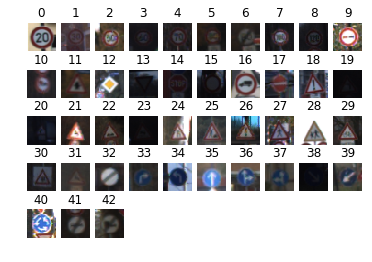

In [3]:
#Please refer to line 298 and 272 in the TrafficSignClassifier cell
TrafficSignClassifier.drawDataSetExample()
%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
#Please refer to line 235 in the TrafficSignClassifier cell
#apply rotate, shift to the samples and adjust the number of samples for each lable to 1500
TrafficSignClassifier.dataAugmentation(1500)

#Don't get confused by the additional "Basic Summary of the DataSet" output:
#In essence the dataAugmentation method reorders the read values, applying rotation, shifting to them
#an make the number of of samples for all labels equal.
#As you can see, the Number of training examples has increased to 64500 which is 43 * 1500

Summary of DataSet after applying Augmentation
	Number of training examples =  64500
	Number of validation examples =  4410
	Number of testing examples =  12630
	Image data shape =  (32, 32)
	Number of classes =  43


### Model Architecture

In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

#use these values to configure the lenet_configuration
c_learningrate = "learningrate"   #default is 0.001
c_mu = "mu"                       # default is 0
c_sigma = "sigma"                 #default is 0.1
c_epoch = "epoch"                 #default is 10
c_batchsize = "batch"             #default is 128
c_keep_prop1 = "kp1"              #default is 0.5
c_keep_prop2 = "kp2"              #default is 0.5

config = { 
          # filter shape + stride          maxpooling filter shape and stride
          "cv1" : ([5,5,3,32], [1,1,1,1]), "p1" : ([1,2,2,1], [1,2,2,1]),
          "cv2" : ([5,5,32,43], [1,1,1,1]), "p2" : ([1,2,2,1], [1,2,2,1]),
          # dimension of the hidden neurons - outputsize
          "fc1" : 120,
          "fc2" : 84,
          "labels" : 43,
          c_epoch : 15,
          c_learningrate : 0.001
        }

#Initialize a trafficSignClassifier object and apply normalization of image data for that instance

#The TrafficSignClassifier gets formed by the configuration above (refer to the markdown for more details)
#In principle this configuraiton will create a architecture similar to LeNet
# Two convolutions
# Two max-pooling layers
# 3 FullyConnected
# 2 Dropout layers with keep-prop of 0.5 (default value)
# Please refer to the def __LeNet() in the initial code-snippet
#PLEASE NOTE: the as a result of the training, you'll get a summary of the 
#             network that was used

#Please refer to line 331 in the TrafficSignClassifier cell
#create an instance of a TrafficSignClassifier with the configuration values given as above
cnn = TrafficSignClassifier(config)

#Please refer to line 398 in the TrafficSignClassifier cell
#apply zero mean normalization to the image data of this instance - i made good experience with that
cnn.normalize_zeroMeanData()

#PLEASE NOTE: the model can be found at line 480

1 Create Instance


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [6]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#train the model and enable persistency in order to store the 
#weight-tensors on hdd.
saveTensors = True
#Please refer to line 584 in the TrafficSignClassifier cell
cnn.TrainCNN(saveTensors)

Training...
EPOCH 1 ...
Instance 1: Validation Accuracy = 0.772
EPOCH 2 ...
Instance 1: Validation Accuracy = 0.870
EPOCH 3 ...
Instance 1: Validation Accuracy = 0.900
EPOCH 4 ...
Instance 1: Validation Accuracy = 0.928
EPOCH 5 ...
Instance 1: Validation Accuracy = 0.934
EPOCH 6 ...
Instance 1: Validation Accuracy = 0.952
EPOCH 7 ...
Instance 1: Validation Accuracy = 0.944
EPOCH 8 ...
Instance 1: Validation Accuracy = 0.950
EPOCH 9 ...
Instance 1: Validation Accuracy = 0.958
EPOCH 10 ...
Instance 1: Validation Accuracy = 0.965
EPOCH 11 ...
Instance 1: Validation Accuracy = 0.954
EPOCH 12 ...
Instance 1: Validation Accuracy = 0.960
EPOCH 13 ...
Instance 1: Validation Accuracy = 0.960
EPOCH 14 ...
Instance 1: Validation Accuracy = 0.964
EPOCH 15 ...
Instance 1: Validation Accuracy = 0.947
Instance 1: On testdata we're achieving accuracy = 0.939
Saved session in ./tsc_cfg_1


Conv1 : 5x5 3->32|
MPool1: 2x2|
Shape1: 14x14x32|
Conv2 : 5x5 32->43|
MPool2: 2x2|
Shape2: 5x5x43|
Conv3 : -|
MPoo

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

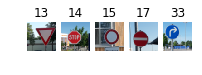

In [7]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

myTestimages = [ ("13_yield.bmp", 13), ("14_stop.bmp", 14), 
                 ("15_noEntry.bmp", 15), ("17_oneway.bmp", 17),
                 ("33_turnRight.bmp", 33)]

TrafficSignClassifier.importCustomImages("./examples", myTestimages)


#draw the images in matplot
TrafficSignClassifier.drawCustomDataSet()
%matplotlib inline

### Predict the Sign Type for Each Image / Analyze Performance

In [8]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

#reload data - custom data is available now which need to be feed to the trafficsignclassifier instance
cnn.reloadData()

#apply zero mean normalization to the custom images
cnn.normalize_zeroMeanData()

#try to match the new signs using trafficsignclassifier
result = cnn.analyzeCustomData()

Restore session in ./tsc_cfg_1
analyzeCustomData (custom) = 0.800
Top K evaluation
Label 13 identified as:
13 with 0.66, 14 with 0.34
12 with 0.00, 1 with 0.00
26 with 0.00
Label 14 identified as:
14 with 0.96, 17 with 0.04
12 with 0.00, 29 with 0.00
10 with 0.00
Label 15 identified as:
15 with 1.00, 13 with 0.00
9 with 0.00, 3 with 0.00
2 with 0.00
Label 17 identified as:
17 with 1.00, 14 with 0.00
26 with 0.00, 18 with 0.00
30 with 0.00
Label 33 identified as:
37 with 1.00, 39 with 0.00
40 with 0.00, 20 with 0.00
38 with 0.00



### Analyze Performance

In [9]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print ( "Accuracy for testdata is {:.3f}".format(result[0]))

Accuracy for testdata is 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [10]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
print ( "Top 5 in Testdata \n", result[1])

Top 5 in Testdata 
 Label 13 identified as:
13 with 0.66, 14 with 0.34
12 with 0.00, 1 with 0.00
26 with 0.00
Label 14 identified as:
14 with 0.96, 17 with 0.04
12 with 0.00, 29 with 0.00
10 with 0.00
Label 15 identified as:
15 with 1.00, 13 with 0.00
9 with 0.00, 3 with 0.00
2 with 0.00
Label 17 identified as:
17 with 1.00, 14 with 0.00
26 with 0.00, 18 with 0.00
30 with 0.00
Label 33 identified as:
37 with 1.00, 39 with 0.00
40 with 0.00, 20 with 0.00
38 with 0.00



### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [11]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")